# Imports

In [106]:
from attention import AttentionLayer

In [107]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

# Data Read

In [108]:
data=pd.read_csv("Dataset.csv")

In [109]:
data.head(1)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...


In [110]:
data.drop_duplicates(subset=['Text'],inplace=True)
#subset=['Text'] searches for duplicates only in the column with name Text(Last column)
#inplace=true will cause all the rows which have same text value to be dropped. 

In [111]:
data.dropna(axis=0,inplace=True)
#this is the instruction to delete all rows with atleast one NaN values

# Data Info

In [112]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88421 entries, 0 to 99999
Data columns (total 10 columns):
Id                        88421 non-null int64
ProductId                 88421 non-null object
UserId                    88421 non-null object
ProfileName               88421 non-null object
HelpfulnessNumerator      88421 non-null int64
HelpfulnessDenominator    88421 non-null int64
Score                     88421 non-null int64
Time                      88421 non-null int64
Summary                   88421 non-null object
Text                      88421 non-null object
dtypes: int64(5), object(5)
memory usage: 7.4+ MB


# Preprocessing

In [169]:
# To remove unnecessary symbols we will define a dictionary for expanding the contractions
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all","y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [170]:
#Stop Words: A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that 
#a search engine has been programmed to ignore, both when indexing entries for searching and 
#when retrieving them as the result of a search query.
#To check the list of stopwords we use the following instruction
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 


[nltk_data] Downloading package stopwords to C:\Users\DRISHTI
[nltk_data]     MAMTANI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [171]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

Defining function for test cleaning

In [172]:
def text_cleaner(text,num):
    String1 = text.lower() #converting to lower case. After this the complete review will be in lower case
    String1 = BeautifulSoup(String1, "lxml").text 
    #Beautiful Soup is a Python library for pulling data out of HTML and XML files. It is used for tasks like extracting the 
    #entire text from a page, extracting all URLs found in a page
    #We create a BeautifulSoup object by passing two arguments:newString(raw HTML content) and lxml(HTML parser we want to use)
    String1 = re.sub(r'\([^)]*\)', '', String1)
    #The re.sub() function in the re module can be used to replace substrings. 
    #The syntax for re.sub() is re.sub(pattern,repl,string). 
    #That will replace the matches in string with repl. 
    String1 = re.sub('"','', String1)
    String1 = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in String1.split(" ")]) 
    #The join() method is a string method and returns a string in which the elements of sequence have been joined by str separator.
    #Here we join with an empty string.
    #The above instruction removes contraction from the string.
    String1 = re.sub(r"'s\b","",String1)
    String1 = re.sub("[^a-zA-Z]", " ", String1) 
    String1 = re.sub('[m]{2,}', 'mm', String1)
    #removes the stopwords
    #tokens will be a list
    if(num==0):
        #for text remove the stop_words
        tokens = [w for w in String1.split() if not w in stop_words]
    else:
        #for summary stop words cannot be removed because the summary is already small. So just take all words in summary as tokens
        tokens=String1.split()
    long_words=[]
    for i in tokens:
        #for each token if length of the token is less than one then eliminate the token/word 
        if len(i)>1:                                                
            long_words.append(i)  
    #join will convert the list back to string and strip() will remove leading spaces if any.
    return (" ".join(long_words)).strip()

Understanding the function text_cleaner

In [173]:
#Sample string to understand the use of contraction mapping and join function
string="ABC ain't def ain't"


In [174]:
#split the words of a sentence at the " " (string.split(" "))
#check each word if it is the key of the dictionary contraction_mapping then replace the key by the value
#if not then keep the word as it is
#string will be list of resultant words
string =[contraction_mapping[t] if t in contraction_mapping else t for t in string.split(" ")]
string

['ABC', 'is not', 'def', 'is not']

In [175]:
#to get the string back from list of words
string=' '.join(string) 
string

'ABC is not def is not'

In [176]:
#Join the list of words so obtanined with an empty string to convert back to string
string = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in string.split(" ")]) 
string


'ABC is not def is not'

In [177]:
string


'ABC is not def is not'

In [178]:
string.split() #string bydefault splits at spaces

['ABC', 'is', 'not', 'def', 'is', 'not']

In [179]:
#This gives words which are not stopwords
tokens = [w for w in string.split() if not w in stop_words]
tokens

['ABC', 'def']

In [180]:
#redefining tokens to understand elimination of short words
tokens=['I','am','a','girl']

In [181]:
long_words=[]
for i in tokens :
    #Initially long words is a empty list
    #Examine each token and if its length is greater than 1 then include it in the long_word list. 
    #In this way all the short words with length 0 or 1 are removed
    if len(i)>1:                                                
        long_words.append(i)  
long_words

['am', 'girl']

In [182]:
" ".join(long_words)

'am girl'

In [183]:
" ".join(long_words).strip()

'am girl'

Calling the function

In [184]:
#call the function
#cleaned_text is an empty string intially. For each entry i.e. row the text column value is 
#taken and cleaned by the function text_cleaner defined above. The cleaned text is added in the cleaned_text list.
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))

In [185]:
#The same function is called for the Summary column as well and in similar manner cleanned_summary list is generated.
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [186]:
cleaned_text[0:4]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal']

In [187]:
cleaned_summary[0:4]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine']

In [188]:
#Adding two new columns namely cleaned_text and cleaned_summary in the data
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

Drop ' '(Empty) rows

In [189]:
#first replace blank spaces with NaN and then drop rows with NaN.
#This can be called a trick to drop ' ' by using dropna
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)


# Understanding the distribution

In [190]:
#For plotting graphs
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []
for i in data['cleaned_text']:
    #for each entry in cleaned_text the number of words are counted in the entry and the count is appended to text_word_count list 
    text_word_count.append(len(i.split()))
for i in data['cleaned_summary']:
    #for each entry in cleaned_summary the number of words are counted in the entry and the count is appended to summary_word_count list  
    summary_word_count.append(len(i.split()))
#A dataframe with two columns is made. 1st column has entries of text_word_count and 2nd has entries of summart_word_count 
df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

        



In [191]:
df.head() #by default 5 entries are displayed

,text,summary
0,23,4
1,18,3
2,39,4
3,17,2
4,13,2


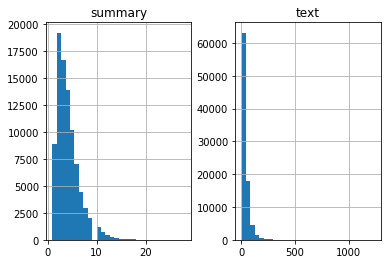

In [192]:
#Plotting the histogram for the dataframe
#Histogram plots the graph between values and frequencies
df.hist(bins = 30)
plt.show()

Lets find out the percentage of summaries below length=8,length=9 and length=10

Find the appropriate max summary length

In [193]:
#initialize count with value 0
#for each entry in cleaned summary, split the cleaned summary at spaces to find number of words and if the no. of word
#are less than or equal to 8 then increement count
#In this way count will have the count of cleaned summaries with number of words less than or equal to 8.
count=0
for i in data['cleaned_summary']:
    if(len(i.split())<=8):
        count=count+1
print(count/len(data['cleaned_summary']))

0.9424926998211739


In [194]:
#initialize count with value 0
#for each entry in cleaned summary, split the cleaned summary at spaces to find number of words and if the no. of word
#are less than or equal to 9 then increement count
#In this way count will have the count of cleaned summaries with number of words less than or equal to 9.
count=0
for i in data['cleaned_summary']:
    if(len(i.split())<=9):
        count=count+1
print(count/len(data['cleaned_summary']))

0.9650383683817371


In [195]:
#initialize count with value 0
#for each entry in cleaned summary, split the cleaned summary at spaces to find number of words and if the no. of word
#are less than or equal to 10 then increement count
#In this way count will have the count of cleaned summaries with number of words less than or equal to 10.
count=0
for i in data['cleaned_summary']:
    if(len(i.split())<=10):
        count=count+1
print(count/len(data['cleaned_summary']))

0.9788690947778256


Lets fix the max cleaned summary length to 10

Find the appropriate max text length

In [196]:
#initialize count with value 0
#foe each entry in cleaned text, split the cleaned text at spaces to find number of words and if the no. of word
#are less than or equal to 20 then increement count
#In this way count will have the count of cleaned texts with number of words less than or equal to 20.
count=0
for i in data['cleaned_text']:
    if(len(i.split())<=20):
        count=count+1
print(count/len(data['cleaned_text']))

0.34857505036557485


In [197]:
#initialize count with value 0
#foe each entry in cleaned text, split the cleaned text at spaces to find number of words and if the no. of word
#are less than or equal to 25 then increement count
#In this way count will have the count of cleaned texts with number of words less than or equal to 25.
count=0
for i in data['cleaned_text']:
    if(len(i.split())<=25):
        count=count+1
print(count/len(data['cleaned_text']))

0.4584851845983204


In [198]:
#initialize count with value 0
#foe each entry in cleaned text, split the cleaned text at spaces to find number of words and if the no. of word
#are less than or equal to 35 then increement count
#In this way count will have the count of cleaned texts with number of words less than or equal to 35.
count=0
for i in data['cleaned_text']:
    if(len(i.split())<=35):
        count=count+1
print(count/len(data['cleaned_text']))

0.6232541820404283


In [199]:
#initialize count with value 0
#foe each entry in cleaned text, split the cleaned text at spaces to find number of words and if the no. of word
#are less than or equal to 45 then increement count
#In this way count will have the count of cleaned texts with number of words less than or equal to 45.
count=0
for i in data['cleaned_text']:
    if(len(i.split())<=45):
        count=count+1
print(count/len(data['cleaned_text']))

0.7336509948615796


Lets fix the max text length as 45

Now selecting those entries in which cleaned text length is less than equal to 45 and cleaned summary length is less than equal to 10

In [200]:
max_summary_len=10
max_text_len=45

In [201]:
#making array of cleaned text entries and cleaned summary entries
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

#short_text and short_summary are initially empty but will contain all the text and summary entries which fall in the desired range
short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    #For all entries if the cleaned_summary has no. of words <=max summary length which is equal to 10 
    #and cleaned_text has no. of words <=max text length which is equal to 45 add such entries to the lists short_text and short_summary
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
#create a dataframe to store the results of short_text and short_summary    
df1=pd.DataFrame({'text':short_text,'summary':short_summary})



In [202]:
df1.head()

,text,summary
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,good quality dog food
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,not as advertised
2,confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat famil...,delight says it all
3,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,cough medicine
4,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,great taffy


Now add the start and end token to each summary. This can be done using lambda function

In [203]:
#This will replace each summary with 'starttoken' as start token concatenated with summary concatenated with 'endtoken' as end token 
#Be sure that the chosen special tokens never appear in the summary
df1['summary'] = df1['summary'].apply(lambda x : 'starttoken '+ x + ' endtoken')

Now splitting data into training and testing sets. Take 90% of the dataset as the training data and evaluate the performance on the remaining 10%

In [212]:
#Sklearn is used to perform the split. This is standard technique to split the dataset.Test size is set to 0.1 i.e. 10%.
#x variable is text
#y variable is summary
#df['text'] and df['summary'] contain respective reviews and summaries in form of array
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(np.array(df1['text']),np.array(df1['summary']),test_size=0.1,random_state=0,shuffle=True)
#xtrain,x_test,y_train,y_test all are numpy arrays containing reviews and summaries

# Preparing the Tokenizer


In [223]:
check=np.array(["This is a great product for money. I will recommend you to buy this"])
check[0]


'This is a great product for money. I will recommend you to buy this'

# Text Tokenizer

In [224]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

In [225]:
#prepare a tokenizer for reviews on training data
t = Tokenizer() 

In [226]:
t
#Output would be  <keras_preprocessing.text.Tokenizer at 0x217e980deb8>

In [227]:
#tokenizing x_train. First x_train which is a numpy array is converted to list
t.fit_on_texts(list(x_train))
#fit_on_texts Updates internal vocabulary based on a list of texts. 
#This method creates the vocabulary index based on word frequency. 
#So if you give it something like, "The cat sat on the mat." 
#It will create a dictionary s.t. word_index["the"] = 1; 
#word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value. 
#0 is reserved for padding. 
#So lower integer means more frequent word (often the first few are stop words because they appear a lot).

Rarewords

In [228]:
#Rare words are those words which do not appear too often
#Defining the threshold as 3. If the words apear less than thrice then the word are rare words.
threshold=3
#count has count of rare words
count=0
#totalcount has the count of total number of words i.e. size of vocabulary
totalcount=0
#frequency has total frequency of all the rare words
frequency=0
#totalfrequency has the sum of all frequencies of all words
totalfrequency=0
#t.word_counts.items() will give items of ordered dictionary i.e.  'key' and 'value' pair. key being the word and value being the number of times it ocuured.
#odict_items([('love', 45148), ('raspberry', 1096), ('shortbread', 276), ('cookies', 6596), ('easy', 10588), ('find', 21556), ....
for key,value in t.word_counts.items():
    #accessing each key value pair
    #totalcount is increemented by 1 as the word encountered is a new word add totalcount by 1
    totalcount=totalcount+1
    #totalfrequency is increemneted by value 
    totalfrequency=totalfrequency+value
    #if value is less than threshold than it is rare word and count is incremented by 1 and frequency by value. 
    if(value<threshold):
        count=count+1
        frequency=frequency+value
print(count)
print(totalcount)
# %of rare words is (number of rare words divided by total number of words) multiplied by 100 i.e. (count divided by totalcount) multiplied by 100
print("% of rare words in vocabulary:",(count/totalcount)*100)
# coverage of rare words is (frequency divided by total frequency) multiplied by 100
print("Total Coverage of rare words:",(frequency/totalfrequency)*100)


19220
32663
% of rare words in vocabulary: 58.843339558521876
Total Coverage of rare words: 1.749112399187831


In [229]:
#prepare a tokenizer for reviews on training data
#totalcount-count is number of common words
#Only common words will be remembered
x_tokenizer = Tokenizer(num_words=totalcount-count)
x_tokenizer.fit_on_texts(list(x_train))
#x_tokenizer.word_index will give
#{'like': 1,'good': 2, 'great': 3,'taste': 4, 'product': 5,'love': 6,'one': 7,....
#This means like appers is the most common word followed by good then great and so on

#convert text sequences into integer sequences
x_train_sequence    =   x_tokenizer.texts_to_sequences(x_train)
#only common words will be remembered
x_test_sequence   =   x_tokenizer.texts_to_sequences(x_test)

#pad_sequences is used to ensure that all sequences in a list have the same length.
#By default this is done by padding 0 in the beginning of each sequence until each sequence has the same length as the longest sequence.
#Here zeros are padded at the end
x_train   =   pad_sequences(x_train_sequence,  maxlen=max_text_len,padding='post')
x_test   =   pad_sequences(x_test_sequence, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [240]:
x_voc

13444

For understanding Tokenizer

In [241]:
from keras.preprocessing.text import Tokenizer
texts = ['a a a', 'b b b b b', 'c c c c c c c','ddd','aa a','aa aa']
#'a a a' is a string with 3 words

In [242]:
tokenizer = Tokenizer(num_words=4)
#num_words: the maximum number of words to keep, based on word frequency. 
#Only the most common num_words-1 words will be kept.
#Tokenizer will use only three most common words and at the same time, it will keep the counter of all words - even when it's obvious that it will not use it later.

In [243]:
tokenizer.fit_on_texts(texts)

In [244]:
tokenizer.word_index
#c is the most common word so will get the value 1.
#b will get value 2
#a will get 3
#aa will get 4
#ddd will get 5
#More times a number appears lesser will be its key

{'c': 1, 'b': 2, 'a': 3, 'aa': 4, 'ddd': 5}

In [245]:
tokenizer.texts_to_sequences(texts)
#only c,b,and a will be remembered
#See "aa a" i.e. 4th index only a is remembered and aa is not so only 3 is the answer

[[3, 3, 3], [2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1], [], [3], []]

# Summary Tokenizer

In [246]:
#prepare a tokenizer for reviews on training data
t1= Tokenizer()   
t1.fit_on_texts(list(y_train))

In [247]:
#Doing the similar thing with summary
#Threshold is set to 5
threshold=5
count=0
totalcount=0
frequency=0
totalfrequency=0

for key,value in t.word_counts.items():
    totalcount=totalcount+1
    totalfrequency=totalfrequency+value
    if(value<threshold):
        count=count+1
        frequency=frequency+value
print(count)
print(totalcount)    
print("% of rare words in vocabulary:",(count/totalcount)*100)
print("Total Coverage of rare words:",(frequency/totalfrequency)*100)

22606
32663
% of rare words in vocabulary: 69.20980926430518
Total Coverage of rare words: 2.619131342233918


In [248]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=totalcount-count) 
y_tokenizer.fit_on_texts(list(y_train))

#convert text sequences into integer sequences
y_train_sequence=y_tokenizer.texts_to_sequences(y_train) 
y_test_sequence=y_tokenizer.texts_to_sequences(y_test) 

#padding zero upto maximum length
y_train=pad_sequences(y_train_sequence, maxlen=max_summary_len, padding='post')
y_test=pad_sequences(y_test_sequence, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc=y_tokenizer.num_words +1

In [249]:
x_test

array([[   6, 1312,   11, ...,    0,    0,    0],
       [  34,   61,  108, ...,    0,    0,    0],
       [ 138, 1678,  289, ...,    0,    0,    0],
       ...,
       [  86,   83, 1657, ...,    0,    0,    0],
       [  12,  333,  404, ...,    0,    0,    0],
       [   6,  519,  177, ...,    0,    0,    0]])

In [250]:
y_voc

10058

In [251]:
#The number of times startoken appears should be equal to length of training data 
y_tokenizer.word_counts['starttoken'],len(y_train)

(57652, 57652)

In [252]:
#Deleting those rows which only contain start and end token
empty=[]
#Checking each element of y train. Each element of y train is a list in itself.
for i in range(len(y_train)):
    count=0
    for j in y_train[i]:
        #checking each element in one element of y_train
            count=count+1
    if(count==2):
        #if there are only 2 non zero elements that is start and end token then the list is actualy empty and append that index 
        #in empty list so that we can delete those rows
        empty.append(i)

#Deleting x and y  for those indices present in empty list that is those rows which only have start and end token
y_train=np.delete(y_train,empty, axis=0)
x_train=np.delete(x_train,empty, axis=0)
#Axis is 0 because rows have to be deleted

In [253]:
#Deleting those rows which only contain start and end token
empty=[]
for i in range(len(y_test)):
    count=0
    for j in y_test[i]:
        if j!=0:
            count=count+1
    if(count==2):
        empty.append(i)

y_test=np.delete(y_test,empty, axis=0)
x_test=np.delete(x_test,empty, axis=0)

# Model Building

In [64]:
#Return Sequences = True: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep

#Return State = True: When return state = True, LSTM produces the hidden state and cell state of the last timestep only

#Initial State: This is used to initialize the internal states of the LSTM for the first timestep

#Stacked LSTM: Stacked LSTM has multiple layers of LSTM stacked on top of each other. This leads to a better representation of the sequence. I encourage you to experiment with the multiple layers of the LSTM stacked on top of each other (it’s a great way to learn this)

In [65]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 45)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 100)      1344400     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer) 

In [66]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [67]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
#If the validation loss increases then stop the model early

In [68]:
history=model.fit([x_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))

Train on 57652 samples, validate on 6324 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
57652/57652 [==============================] - 1993s 35ms/sample - loss: 2.7432 - val_loss: 2.4691
Epoch 2/50
57652/57652 [==============================] - 2055s 36ms/sample - loss: 2.4533 - val_loss: 2.3235
Epoch 3/50
57652/57652 [==============================] - 2051s 36ms/sample - loss: 2.3197 - val_loss: 2.2287
Epoch 4/50
57652/57652 [==============================] - 2052s 36ms/sample - loss: 2.2382 - val_loss: 2.1668
Epoch 5/50
57652/57652 [==============================] - 2045s 35ms/sample - loss: 2.1799 - val_loss: 2.1326
Epoch 6/50
57652/57652 [==============================] - 2047s 36ms/sample - loss: 2.1352 - val_loss: 2.1025
Epoch 7/50
57652/57652 [==============================] - 2038s 35ms/sample - loss: 2.0981 - val_loss: 2.0816
Epoch 8/50
57652/57652 [==============================] - 2045s 35ms/sample - loss: 2.0661 - val_loss: 2.0605
Epoch 9/50
57652/57652 

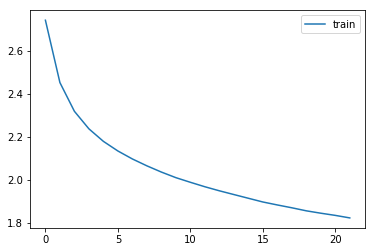

In [254]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.legend()


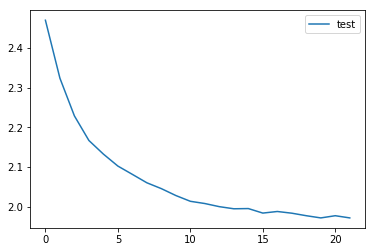

In [255]:
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
#As it is visible that validation loss decresed till 25 epochs and then it remained constant in 26th epoch so 

In [256]:
y_tokenizer.index_word
#starttoken and endtoken have the most frequency because they appear in each summary

{1: 'starttoken',
 2: 'endtoken',
 3: 'great',
 4: 'good',
 5: 'the',
 6: 'not',
 7: 'for',
 8: 'best',
 9: 'and',
 10: 'love',
 11: 'it',
 12: 'my',
 13: 'coffee',
 14: 'tea',
 15: 'this',
 16: 'is',
 17: 'product',
 18: 'but',
 19: 'delicious',
 20: 'to',
 21: 'taste',
 22: 'very',
 23: 'of',
 24: 'dog',
 25: 'excellent',
 26: 'yummy',
 27: 'flavor',
 28: 'these',
 29: 'like',
 30: 'tasty',
 31: 'price',
 32: 'in',
 33: 'food',
 34: 'favorite',
 35: 'ever',
 36: 'too',
 37: 'stuff',
 38: 'loves',
 39: 'so',
 40: 'snack',
 41: 'you',
 42: 'as',
 43: 'are',
 44: 'awesome',
 45: 'on',
 46: 'with',
 47: 'dogs',
 48: 'just',
 49: 'healthy',
 50: 'yum',
 51: 'free',
 52: 'better',
 53: 'chocolate',
 54: 'them',
 55: 'nice',
 56: 'tastes',
 57: 'perfect',
 58: 'no',
 59: 'have',
 60: 'wonderful',
 61: 'than',
 62: 'really',
 63: 'treat',
 64: 'what',
 65: 'treats',
 66: 'sweet',
 67: 'at',
 68: 'tasting',
 69: 'buy',
 70: 'quality',
 71: 'bad',
 72: 'hot',
 73: 'cup',
 74: 'do',
 75: 'one',

In [257]:
x_tokenizer.index_word
#'like' is most frequent in review followed by 'good' and so on 

{1: 'like',
 2: 'good',
 3: 'great',
 4: 'taste',
 5: 'product',
 6: 'love',
 7: 'one',
 8: 'coffee',
 9: 'flavor',
 10: 'would',
 11: 'tea',
 12: 'really',
 13: 'get',
 14: 'amazon',
 15: 'best',
 16: 'price',
 17: 'buy',
 18: 'much',
 19: 'food',
 20: 'time',
 21: 'find',
 22: 'little',
 23: 'use',
 24: 'tried',
 25: 'better',
 26: 'well',
 27: 'make',
 28: 'also',
 29: 'chocolate',
 30: 'eat',
 31: 'dog',
 32: 'try',
 33: 'even',
 34: 'bought',
 35: 'delicious',
 36: 'found',
 37: 'order',
 38: 'sweet',
 39: 'tastes',
 40: 'could',
 41: 'loves',
 42: 'recommend',
 43: 'favorite',
 44: 'cup',
 45: 'used',
 46: 'drink',
 47: 'bag',
 48: 'cannot',
 49: 'sugar',
 50: 'store',
 51: 'free',
 52: 'nice',
 53: 'first',
 54: 'way',
 55: 'made',
 56: 'go',
 57: 'box',
 58: 'got',
 59: 'perfect',
 60: 'dogs',
 61: 'snack',
 62: 'easy',
 63: 'since',
 64: 'ordered',
 65: 'mix',
 66: 'think',
 67: 'day',
 68: 'hot',
 69: 'ever',
 70: 'water',
 71: 'flavors',
 72: 'many',
 73: 'bit',
 74: 'still'

In [258]:
y_tokenizer.word_index
#difference between word_index and index_word is that in word_index word comes first followed by index whereas in index_word it is the opposite

{'starttoken': 1,
 'endtoken': 2,
 'great': 3,
 'good': 4,
 'the': 5,
 'not': 6,
 'for': 7,
 'best': 8,
 'and': 9,
 'love': 10,
 'it': 11,
 'my': 12,
 'coffee': 13,
 'tea': 14,
 'this': 15,
 'is': 16,
 'product': 17,
 'but': 18,
 'delicious': 19,
 'to': 20,
 'taste': 21,
 'very': 22,
 'of': 23,
 'dog': 24,
 'excellent': 25,
 'yummy': 26,
 'flavor': 27,
 'these': 28,
 'like': 29,
 'tasty': 30,
 'price': 31,
 'in': 32,
 'food': 33,
 'favorite': 34,
 'ever': 35,
 'too': 36,
 'stuff': 37,
 'loves': 38,
 'so': 39,
 'snack': 40,
 'you': 41,
 'as': 42,
 'are': 43,
 'awesome': 44,
 'on': 45,
 'with': 46,
 'dogs': 47,
 'just': 48,
 'healthy': 49,
 'yum': 50,
 'free': 51,
 'better': 52,
 'chocolate': 53,
 'them': 54,
 'nice': 55,
 'tastes': 56,
 'perfect': 57,
 'no': 58,
 'have': 59,
 'wonderful': 60,
 'than': 61,
 'really': 62,
 'treat': 63,
 'what': 64,
 'treats': 65,
 'sweet': 66,
 'at': 67,
 'tasting': 68,
 'buy': 69,
 'quality': 70,
 'bad': 71,
 'hot': 72,
 'cup': 73,
 'do': 74,
 'one': 75,

In [259]:
y_index_word=y_tokenizer.index_word
x_index_word=x_tokenizer.index_word
y_word_index=y_tokenizer.word_index

# Inference

In [75]:
# For building the model 3 LSTM encoder layers were used along with decoder
#Now model is decoded
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [76]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    #It is an array of one row and one column
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    #target_seq will be array of one row and one column with value as 1
    target_seq[0, 0] = y_word_index['starttoken']
    #initializing stop condition to be false
    stop_condition = False
    #decode sentence initially is empty
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = y_index_word[sampled_token_index]
        
        if(sampled_token!='endtoken'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'endtoken'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

Understanding

In [77]:
target_seq = np.zeros((1,1))
target_seq

array([[0.]])

In [78]:
target_seq[0, 0] = y_word_index['starttoken']
target_seq

array([[1.]])

In [79]:
x=np.arange(8)
x

array([0, 1, 2, 3, 4, 5, 6, 7])

In [80]:
x.reshape(1,8)
# 1 D array converted to 2D array with one row and 8 columns

array([[0, 1, 2, 3, 4, 5, 6, 7]])

In [260]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=y_word_index['starttoken']) and i!=y_word_index['endtoken']):
            newString=newString+y_index_word[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+x_index_word[i]+' '
    return newString

In [261]:
for i in range(0,100):
    print("Review:",seq2text(x_train[i]))
    print("Original summary:",seq2summary(y_train[i]))
    print("Predicted summary:",decode_sequence(x_train[i].reshape(1,max_text_len)))
    print("\n")

Review: love raspberry shortbread cookies easy find great buttery enough raspberry filling order various quantities 
Original summary: really good 
Predicted summary:  great cookies


Review: superb business think item could shipped received quicker unless driven local store picked wish internet businesses would strive transaction way adds confidence credibility world 
Original summary: excellent vendor 
Predicted summary:  great product


Review: bought box spain loved came home went amazon good price lots choose love spreading things crackers using tuna chicken salad soup must try know good flavors really 
Original summary: these crackers rock 
Predicted summary:  good stuff


Review: best easy work abundance flavor used son wedding cake recieved multi compliments used small leftover amount cheesecake along belgium chocolate needless say disappeared quickly cake four layers deep 
Original summary: marzipan biermann 
Predicted summary:  great product


Review: within five minutes mont

Predicted summary:  great snack


Review: like others ordered excellent cookies disappointed amazon packaging good price kept us coming back appears amazon listened everyone complaints recent order arrived rolls cookies shipping box clever way prevented damage broken end pieces kudos amazon 
Original summary: now with improved packing by amazon 
Predicted summary:  great cookies


Review: love product beware amazon covered expired expiration date sticker shame amazon 
Original summary: they tried to cover the item expiration with sticker 
Predicted summary:  dented cans


Review: tried spaghetti hopes would way resemble wheat pasta used love eat even come close taste ricey bland falls apart despite following cooking directions many good wf gf pasta products days one 
Original summary: not very good wheat free gluten free pasta 
Predicted summary:  not gluten free


Review: actually decided write review bad ones almost prevented purchasing like reviewers need product dog tablespoon ever

Predicted summary:  not bad


Review: got bottle hoping use cocktails sodas etc tried using mixer yet adding seltzer water make italian soda sweet sure would hold flavors even simply flavor soda water refreshing 
Original summary: great stuff 
Predicted summary:  good stuff


Review: mini bags great watching weight bag contains cups low fat popcorn counts weight watcher point great afternoon evening snack watch closely popping burn easily 
Original summary: great for weight watchers 
Predicted summary:  great popcorn


Review: xylitol products read internet warning pet owners product dogs would probably include pets general think people need aware dogs eat anything smell even gum sweets made sweetner would dangerous 
Original summary: just warning alert 
Predicted summary:  not the best


Review: nothing write home much peanut butter flavor chocolate chewy compared granola bars get much crunch bite bars small compare granola bars terms consistency flavor like peanut butter chocolate re

In [262]:
for i in range(0,100):
    print("Review:",seq2text(x_test[i]))
    print("Original summary:",seq2summary(y_test[i]))
    print("Predicted summary:",decode_sequence(x_test[i].reshape(1,max_text_len)))
    print("\n")

Review: love lipton tea strawberry best one recommend ounce water bottle bit strong ounce water better dont use whole packet 
Original summary: pleased 
Predicted summary:  love this tea


Review: bought snack local supermarket whole family bags minutes ordered box flavor mix ever since everyone hooked take bag school everyday great healthy snack fried calories huge serving way better pop chips huge smart fans 
Original summary: love smart fries 
Predicted summary:  great snack


Review: purchased assortment three times love quality quantity variety excellent value much prefer brewing pods vs grounds consistency pods much greater grounds speed convenience make brainer using pods sampler pack like like trying different coffee shop every day 
Original summary: great coffee great value 
Predicted summary:  great coffee


Review: lived island st around years ago drink available coca cola plant drink since back states remember amazing 
Original summary: one of the best 
Predicted summary:  

Predicted summary:  great tea


Review: note half size normal baking soda fridge packs sides rip top put fridge buy type 
Original summary: not what expected 
Predicted summary:  great product


Review: love candy tired sugar well werther original sugar free version best unlike sugar free candy taste exactly like sugar cousins absolutely taste none realize sugar free unless someone tells perfect diabetics want snack cannot handle sugar keep package handy sorry 
Original summary: good as original but no sugar 
Predicted summary:  sugar free sugar free


Review: still good coffee doubled cost half price percent coupon also available half amazon charging target walmart 
Original summary: on review 
Predicted summary:  good coffee


Review: advertisement product misleading lies right getting says getting oz packets mix getting oz oz packets high price easily misled amount product walmart approx around seller sold rip 
Original summary: ripped off 
Predicted summary:  not for me


Review: b

Predicted summary:  my dogs love these


Review: dr pepper pretty darn close love zevia sodas purchasing flavor 
Original summary: great soda 
Predicted summary:  great taste


Review: wanted high quality brand highly recommended 
Original summary: best deal 
Predicted summary:  great product


Review: love taste coffee last order four boxes every cup tear rip internal filter thus grounds flow cup coffee value coffee drinkable wolfgang needs correct flaw packaging order waste 
Original summary: grounds for not ordering again 
Predicted summary:  great coffee but not great


Review: great quick ordinary meal love curry never chance eat fix 
Original summary: great for quick and tastey meal 
Predicted summary:  great for cooking


Review: gummy candy looks like cherries see casino slots bigger classic bear shaped like gummy bear counterpart tough rubbery sticky glues teeth sweet neither right combination flavors taste haribo claims biggest gummy bear manufacturer world 
Original summary:

In [277]:
check=np.array(["This is a great product for money. I ordered it for my sister and she loved the product. She is very happy and so am I"])
check_seq=x_tokenizer.texts_to_sequences(check)
check_test=pad_sequences(check_seq, maxlen=max_text_len, padding='post')
print("Predicted summary:",decode_sequence(check_test[0].reshape(1,max_text_len)))

Predicted summary:  great product
